# Find me an asteroid

In this notebook we will show you how a machine may find asteroids in astronomical images.  Although this task is normally reserved to trained eyes, advances in computing allows us to perform the "dirty" tasks in the process with the help of algorithms.  

## Step 0: Before starting

We will need to load several external tools, our own routines and more importantly load the package fonfiguration *aisteroid.cfg*.  Be sure that you set the variables in this file.

In [1]:
from aisteroid import *
%matplotlib nbagg
plt.ion()

Configuration:
{ 'AST_DIR': '/home/astrometry/astrometry/',
  'CFG': 'example',
  'DATA_DIR': 'data/',
  'HOME_DIR': '/home/jzuluaga/Astrometry/AIsteroid',
  'IMAGE_DIR': 'images/',
  'INPUT_DIR': 'input/',
  'OVERWRITE': 0,
  'PHOTOPLOT': 1,
  'RADIUS': 3,
  'REP_DIR': 'data/reports/',
  'SCR_DIR': 'scratch/',
  'SET': 'example',
  'SETS_DIR': 'data/sets/',
  'SEX_DIR': '/home/astrometry/sextractor/',
  'SUMMARY': 1,
  'TEAM': 'NEA',
  'TEAM_COUNTRY': 'Colombia',
  'TEAM_MEMBERS': 'J.Ospina, L. Piedraita, I.Moreno, S.Lopez, J. Zuluaga'}


---

## Step 1: The observation set

Choose the observation set you want to analyse

In [2]:
print("Available datasets:")
out=System("for i in $(ls "+CONF.SETS_DIR+"*.zip);do echo -n $(basename $i |cut -f 1 -d'.');echo -n ', ';done")

Available datasets:
example, ps1-20170913_1_set140, ps1-20170913_1_set141, ps1-20170913_1_set142, ps1-20170913_1_set143, ps1-20170913_4_set020, ps1-20170913_4_set021, ps1-20170914_11_set176, ps1-20170914_11_set177, ps1-20170914_11_set178, ps1-20170914_11_set179, ps1-20170914_11_set180, ps1-20170914_11_set181, ps1-20170914_11_set182, ps1-20170914_11_set183, ps1-20170914_4_set096, ps1-20170914_4_set104, ps1-20170914_4_set105, ps1-20170914_4_set106, ps1-20170914_4_set107, ps1-20170914_4_set108, ps1-20170914_4_set109, ps1-20170914_4_set110, ps1-20170915_4_set045, ps1-20170915_4_set046, ps1-20170915_4_set047, ps1-20170915_4_set048, ps1-20170915_4_set049, ps1-20170915_4_set050, ps1-20170915_4_set051,


In [3]:
#CONF.SET="example"
#CONF.SET="ps1-20170914_4_set096"
CONF.SET="ps1-20170914_11_set177"

In [4]:
#Output directory                                                                                                                                                                    
OUT_DIR=CONF.SCR_DIR+CONF.SET+"/"

#File to pickle analysis results                                                                                                                                                     
AIA=OUT_DIR+"analysis.aia"

#Observatory configuration file                                                                                                                                                      
CFG=[line.rstrip('\n') for line in open(CONF.SETS_DIR+CONF.CFG+".cfg")]

#Basic information about the observatory
MPCCODE=Config(CFG,"MPCCode")
OBSERVER=Config(CFG,"Observer")
TELESCOPE=Config(CFG,"Telescope")[0]

---

## Step 2: Unpack and read images

It is assumed that the observations set is packed as a *zip* file and contains the images in FITS format, sorted in alphabetical order

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#UNPACK THE IMAGE SET
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
setfile=CONF.SETS_DIR+CONF.SET+".zip"
if not os.path.isfile(setfile):
    error("No set file '%s'"%setfile)
out=System("rm -rf "+OUT_DIR)
out=System("mkdir -p "+OUT_DIR)
out=System("cp "+CONF.INPUT_DIR+"template/* "+OUT_DIR)
out=System("unzip -j -o -d "+OUT_DIR+" "+setfile)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#READ THE IMAGES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
images=[]
print("Reading images")
for image in sorted(glob.glob(OUT_DIR+"*.fits")):
    print("\tReading image "+image)
    hdul=fits.open(image)
    im=dict()
    im["file"]=image.split("/")[-1].replace(".fits","")
    im["header"]=hdul[0].header
    im["data"]=hdul[0].data
    im["obstime"]=hdul[0].header["DATE-OBS"]
    im["unixtime"]=date2unix(im["obstime"])
    images+=[im]
    hdul.close()
    f=open(OUT_DIR+"%s.head"%im["file"],"w")
    f.write(im["header"].tostring("\n"))
    f.close()
    nimgs=len(images)
if not len(images):
    print("No images provided.")
print("\tDone.")

Archive:  data/sets/ps1-20170914_11_set177.zip
  inflating: scratch/ps1-20170914_11_set177/o8010g0397o.1300882.ch.1992578.XY63.p01.fits
  inflating: scratch/ps1-20170914_11_set177/o8010g0361o.1300846.ch.1992542.XY63.p01.fits
  inflating: scratch/ps1-20170914_11_set177/o8010g0343o.1300828.ch.1992524.XY63.p01.fits
  inflating: scratch/ps1-20170914_11_set177/o8010g0379o.1300864.ch.1992560.XY63.p01.fits
Reading images
	Reading image scratch/ps1-20170914_11_set177/o8010g0343o.1300828.ch.1992524.XY63.p01.fits
	Reading image scratch/ps1-20170914_11_set177/o8010g0361o.1300846.ch.1992542.XY63.p01.fits
	Reading image scratch/ps1-20170914_11_set177/o8010g0379o.1300864.ch.1992560.XY63.p01.fits
	Reading image scratch/ps1-20170914_11_set177/o8010g0397o.1300882.ch.1992578.XY63.p01.fits
	Done.


	Not annotated ('scratch/ps1-20170914_11_set177//ps1-20170914_11_set177.gif')


<IPython.core.display.Javascript object>


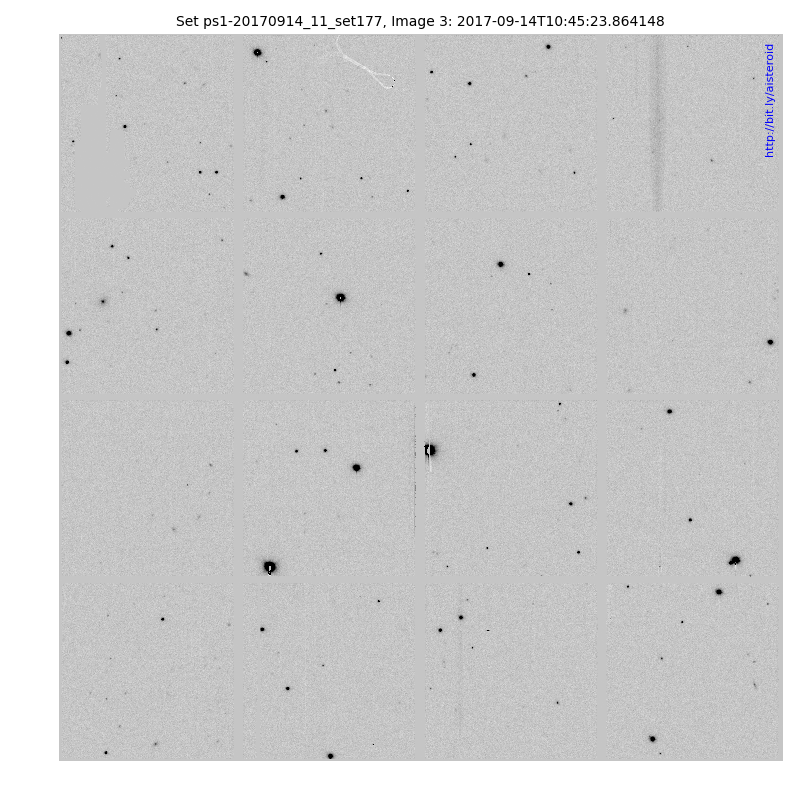

In [6]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#ANIMATION
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
animfile="%s/%s.gif"%(OUT_DIR,CONF.SET)
print("\tNot annotated ('%s')"%animfile)

#Figure
fig=plt.figure(figsize=(8,8))

#Show first image
imgargs=dict(cmap='gray_r',vmin=0,vmax=700)
im=plt.imshow(images[0]["data"],animated=True,**imgargs)

#Title
tm=plt.title("Set %s, Image 0: "%CONF.SET+images[0]["obstime"],fontsize=10)

#Water mark
waterMark(fig.gca())

#Basic decoration
plt.axis("off")
fig.tight_layout()

#Update figure
def updatefig(i):
    #Select image
    iimg=i%nimgs
    im.set_array(images[iimg]["data"])
    tm.set_text("Set %s, Image %d: "%(CONF.SET,iimg)+images[iimg]["obstime"])
    return im,

#Create animation
ani=animation.FuncAnimation(fig,updatefig,frames=range(nimgs),
                            interval=1000,repeat_delay=1000,
                            repeat=True,blit=True)

#Save animation
out=System("rm -rf %s/blink*"%OUT_DIR)
ani.save(OUT_DIR+'blink.html')
time.sleep(1)
out=System("convert -delay 100 $(find %s -name 'blink*.png' -o -name 'frame*.png' |grep -v '04' |sort) %s"%(OUT_DIR,animfile))
out=System("rm -rf blink*")

---

## Step 3: Telescope and CCD Properties

Some procedures need to know some of the properties of the equipment used to get the images.

In [7]:
print("Telescope & CCD Properties:")
FOCAL=Config(CFG,"FocalLength") #mm
PW=Config(CFG,"PixelWide") #mm
PH=Config(CFG,"PixelHigh") #mm
SIZEX=images[0]["header"]["NAXIS1"]
SIZEY=images[0]["header"]["NAXIS2"]
PWD=np.arctan(PW/FOCAL)*RAD
PHD=np.arctan(PW/FOCAL)*RAD
PXSIZE=(PWD+PHD)/2
print("\tFocal lenght (mm) :",FOCAL)
print("\tPixel size (x mm,y mm) :",PW,PH)
print("\tImage size (x px,y px) :",SIZEX,SIZEY)
print("\tPixel size (arcsec):",PXSIZE/ARCSEC)
print("\tCamera field (x deg,y deg) :",SIZEX*PWD,SIZEY*PHD)

Telescope & CCD Properties:
	Focal lenght (mm) : 8070.0
	Pixel size (x mm,y mm) : 0.01 0.01
	Image size (x px,y px) : 2423 2434
	Pixel size (arcsec): 0.255594555449
	Camera field (x deg,y deg) : 0.172029335514 0.172810318878


---

## Step 4: Extract sources

Once you have the images you may attempt at extracting the *sources*, ie. anything in the image that *resembles* a stellar object.  We perform this task using a third party application, [SEXtractor](https://www.astromatic.net/software/sextractor).

In [8]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#EXTRACTING SOURCES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("SEXtracting sources")
for i,image in enumerate(images):
    file=image["file"]
    header=image["header"]
    #SEX COMMAND
    print("\tRunning SEXtractor over %s..."%file)
    opts=""
    opts+=" "+"-c asteroid.sex"
    cmd=CONF.SEX_DIR+"bin/sex "+opts+" "+file+".fits"
    sys="cd "+OUT_DIR+";"+cmd
    out=System(sys)
    if out[-1][0]!=0:
        print("\t\tError processing image")
        print(out[-1][1])
    else:
        print("\t\tExtraction successful")
        #STORE RESULTS
        image["sex_output"]=out[-1][1]
        System("cd "+OUT_DIR+";cp asteroid.cat %s.cat"%file,False)
        hdul=fits.open(OUT_DIR+"%s.cat"%file)
        image["sourcexxy_header"]=hdul[1].header
        image["sourcexxy"]=hdul[1].data
        hdul.close()
        print("\t\t%d sources saved."%len(image["sourcexxy"]))
print("\tDone.")

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#COMPILING SOURCES INFORMATION
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("Compiling all sources...")
allsources=pd.DataFrame()
for i,image in enumerate(images):
    srcxys=pd.DataFrame(image["sourcexxy"])
    alls=pd.concat([srcxys],axis=1)

    #Aligned coordinates
    alls["T"]=image["unixtime"]
    alls["X_ALIGN"]=0.0
    alls["Y_ALIGN"]=0.0
    
    #Astrometry
    alls["RA"]=0.0
    alls["DEC"]=0.0
    alls["ERR_RA"]=0.0
    alls["ERR_DEC"]=0.0
        
    #Alignment attributes
    alls["IMG"]=i #In which image is this source
    alls["STAR"]=0 #Is this a star?

    #Detection attributes
    alls["OBJ"]=0 #To which object it belongs (detection procedure)
    alls["NIMG"]=1 #In how many images is the object present (detection procedure)
    alls["MOBJ"]=0 #To which moving object it belongs (detection procedure)

    #Photometric attributes
    alls["MAG_ASTRO"]=0.0
    alls["ERR_MAG_ASTRO"]=0.0
    
    allsources=allsources.append(alls)

allsources.sort_values(by="MAG_BEST",ascending=True,inplace=True)
allsources.reset_index(inplace=True)

for i,image in enumerate(images):
    image["xy"]=allsources[allsources.IMG==i][["X_IMAGE","Y_IMAGE"]].values

SEXtracting sources
	Running SEXtractor over o8010g0343o.1300828.ch.1992524.XY63.p01...
		Extraction successful
		398 sources saved.
	Running SEXtractor over o8010g0361o.1300846.ch.1992542.XY63.p01...
		Extraction successful
		457 sources saved.
	Running SEXtractor over o8010g0379o.1300864.ch.1992560.XY63.p01...
		Extraction successful
		471 sources saved.
	Running SEXtractor over o8010g0397o.1300882.ch.1992578.XY63.p01...
		Extraction successful
		440 sources saved.
	Done.
Compiling all sources...


<IPython.core.display.Javascript object>


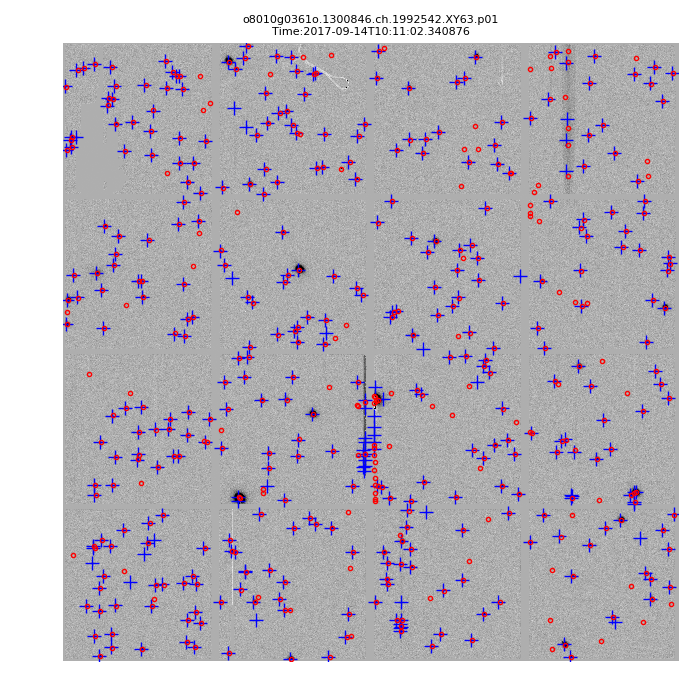

In [9]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#SHOW THE SOURCES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Which image do you want the sources be shown?
iimg=1
image=images[iimg]

fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
ax=axs
imgargs=dict(cmap='gray_r',vmin=0,vmax=500)
ax.imshow(image["data"],**imgargs)       
ax.axis("off")
itime=image["header"]["DATE-OBS"]
ax.set_title(image["file"]+"\n"+"Time:"+itime,fontsize=8,position=(0.5,1.0))

#Show the sources
ax.plot(images[0]["xy"][:,0]-1,images[0]["xy"][:,1]-1,'b+',ms=10,mfc='None')
ax.plot(image["xy"][:,0]-1,image["xy"][:,1]-1,'ro',ms=3,mfc='None')

fig.tight_layout()
fig.savefig(OUT_DIR+"sources-%d.png"%iimg)

**NOTES ON IMAGE**: Red circles show the sources in the selected images. Blue crosses are the sources detected in the first image. You may notice that there are sources in one image that were not detected in the other one.  Additionally if you make a zoom in in any area of the images you will see that the sources positions among images differ by a few pixels.  These are errors in the pointing of the telescope.

---

## Step 5: Align the sources

Before looking for moving objects we should be sure that the sources as properly aligned

In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#FIND ALIGNMENT PARAMETERS
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("Finding alignment transformation")
print("\tReference image:",images[0]["file"])

#Reference image is not aligned
allsources.loc[allsources.IMG==0,"X_ALIGN"]=allsources[allsources.IMG==0]["X_IMAGE"]
allsources.loc[allsources.IMG==0,"Y_ALIGN"]=allsources[allsources.IMG==0]["Y_IMAGE"]

columns=["X_IMAGE","Y_IMAGE"]
for i,image in enumerate(images[1:]):
    print("\tAligning image:",images[i]["file"])
    imsources=allsources[allsources.IMG==(i+1)]
    
    #Measure initial misalignment
    ta,sa=matchSources(imsources[columns],
                       allsources[allsources.IMG==i][columns])
    mab=np.abs(sa-ta).mean()
    print("\t\tAverage distance before alignment:",mab)

    #Align
    tr,(ta,sa)=forceAlignment(allsources,i+1,i)
    image["transform"]=tr

    #Measure misalignment after procedure
    sp=[]
    for j in range(ta.shape[0]):sp+=tr(ta[j,:]).tolist()
    sp=np.array(sp)
    maa=np.abs(sa-sp).mean()
    print("\t\tAverage distance after alignment:",maa)
    print("\t\tYou improved the alignment by a factor of ",mab/maa)
    
    #Align all coordinates
    xy=imsources[columns].values
    xya=[]
    for j in range(xy.shape[0]):
        xyr=xy[j,:]
        for ia in range(i+1,0,-1):
            tr=images[ia]["transform"]
            xyr=tr(xyr).tolist()
        xya+=xyr
    xya=np.array(xya)
    imsources[["X_ALIGN","Y_ALIGN"]]=pd.DataFrame(xya,columns=["X_ALIGN","Y_ALIGN"],index=imsources.index)
    allsources.loc[allsources.IMG==(i+1),["X_ALIGN","Y_ALIGN"]]=imsources
    
    #Measure alignment
    print("\t\tChecking alignment in the whole image:")

    ta,sa=matchSources(allsources[allsources.IMG==(i+1)],allsources[allsources.IMG==0])
    print("\t\t\tAverage distance before alignment:",np.abs(sa-ta).mean())

    ta,sa=matchSources(pd.DataFrame(allsources.loc[allsources.IMG==(i+1),["X_ALIGN","Y_ALIGN"]].values,columns=columns),
                       pd.DataFrame(allsources.loc[allsources.IMG==0,["X_ALIGN","Y_ALIGN"]].values,columns=columns))
    print("\t\t\tAverage distance after alignment:",np.abs(sa-ta).mean())

print("Done.")

Finding alignment transformation
	Reference image: o8010g0343o.1300828.ch.1992524.XY63.p01
	Aligning image: o8010g0343o.1300828.ch.1992524.XY63.p01
		Average distance before alignment: 2.42101
		Average distance after alignment: 0.353148045595
		You improved the alignment by a factor of  6.85550274166
		Checking alignment in the whole image:
			Average distance before alignment: 2.42101
			Average distance after alignment: 0.577013533464
	Aligning image: o8010g0361o.1300846.ch.1992542.XY63.p01
		Average distance before alignment: 4.14532
		Average distance after alignment: 0.776208868908
		You improved the alignment by a factor of  5.34046969148
		Checking alignment in the whole image:
			Average distance before alignment: 5.55015
			Average distance after alignment: 0.951754268482
	Aligning image: o8010g0379o.1300864.ch.1992560.XY63.p01
		Average distance before alignment: 5.43464
		Average distance after alignment: 0.561392487011
		You improved the alignment by a factor of  9.6806415

<IPython.core.display.Javascript object>


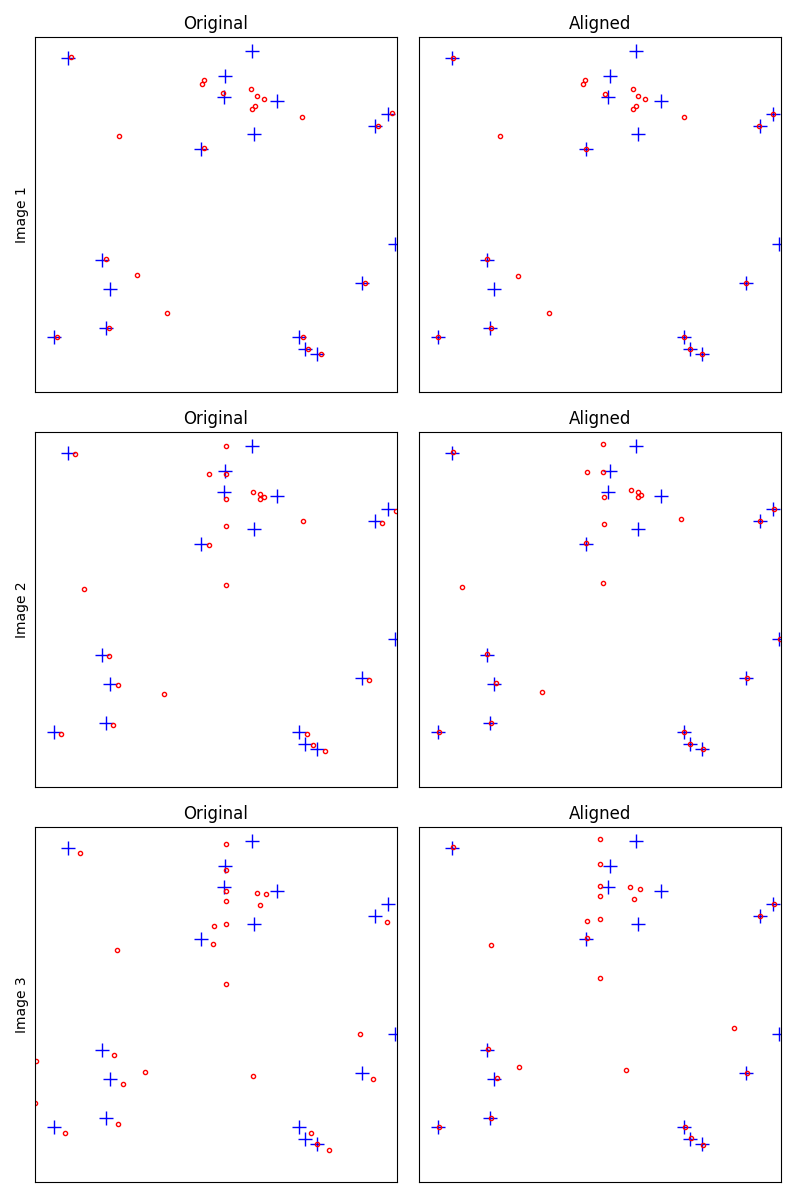

In [11]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#RESULT OF THE ALIGNMENT PROCEDURE
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
# Figure
fig,axs=plt.subplots(3,2,sharex=True,sharey=True,figsize=(8,12))

dx=SIZEX/10
dy=SIZEY/10

#Show the misaligned sources
images[0]["xy_aligned"]=allsources.loc[allsources.IMG==0,["X_ALIGN","Y_ALIGN"]].values
for i,image in enumerate(images[1:]):
    iimg=i+1
    imsource=allsources[allsources.IMG==(i+1)]
    image["xy"]=imsource[["X_IMAGE","Y_IMAGE"]].values
    image["xy_aligned"]=imsource[["X_ALIGN","Y_ALIGN"]].values
    
    xcen=image["xy"][:,0].mean()
    ycen=image["xy"][:,1].mean()
    
    ax=axs[i,0]
    ax.plot(images[0]["xy"][:,0]-1,images[0]["xy"][:,1]-1,'b+',ms=10,mfc='None')
    ax.plot(image["xy"][:,0]-1,image["xy"][:,1]-1,'ro',ms=3,mfc='None')

    ax.set_title("Original")
    ax.set_ylabel("Image %d"%iimg)

    ax=axs[i,1]
    ax.set_title("Aligned")
    ax.plot(images[0]["xy_aligned"][:,0]-1,images[0]["xy_aligned"][:,1]-1,'b+',ms=10,mfc='None')
    ax.plot(image["xy_aligned"][:,0]-1,image["xy_aligned"][:,1]-1,'ro',ms=3,mfc='None')
    
#Zoom in the center
ax.set_xlim((xcen-dx,xcen+dx))
ax.set_ylim((ycen-dy,ycen+dy))

for ax in mat2lst(axs):
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig(OUT_DIR+"alignment-%d.png"%iimg)

**NOTES ON IMAGE**: Red circles show the sources in the corresponding images, blue crosses are the sources detected in the first image.

---

## Step 6: Perform the Astrometry

In this step we identify the stars present in the field

In [12]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#BUILD DATABASE OF CLOSE SOURCES
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("Looking for star in the field covered by the images...")
rmin=allsources["ALPHA_J2000"].min()
rmax=allsources["ALPHA_J2000"].max()
dmin=allsources["DELTA_J2000"].min()
dmax=allsources["DELTA_J2000"].max()
rmean=(rmin+rmax)/2;dr=(rmax-rmin)/2
dmean=(dmin+dmax)/2;dd=(dmax-dmin)/2
ra=dec2sex(rmean/15)
dec=dec2sex(dmean)
ras="%d %d %.2f"%(int(ra[0]),int(ra[1]),ra[2])
des="%d %d %.2f"%(int(dec[0]),int(dec[1]),dec[2])
radius=np.sqrt(dr**2+dd**2)

columns=['_RAJ2000','_DEJ2000','R1mag']
v=Vizier(columns=columns)
v.ROW_LIMIT=-1
#radius=Angle(radius,"deg"),
result=v.query_region("%s %s"%(ras,des),
                      width=Angle(2*dr,"deg"),height=Angle(2*dd,"deg"),
                      catalog='USNOB1')[0]
cond=result["R1mag"]>0
stars=pd.DataFrame(rec2arr(result[cond]),
                   columns=["ALPHA_J2000","DELTA_J2000","Rmag"])
print("\tNumber of reference stars found:",len(stars))

Looking for star in the field covered by the images...
	Number of reference stars found: 217


<IPython.core.display.Javascript object>


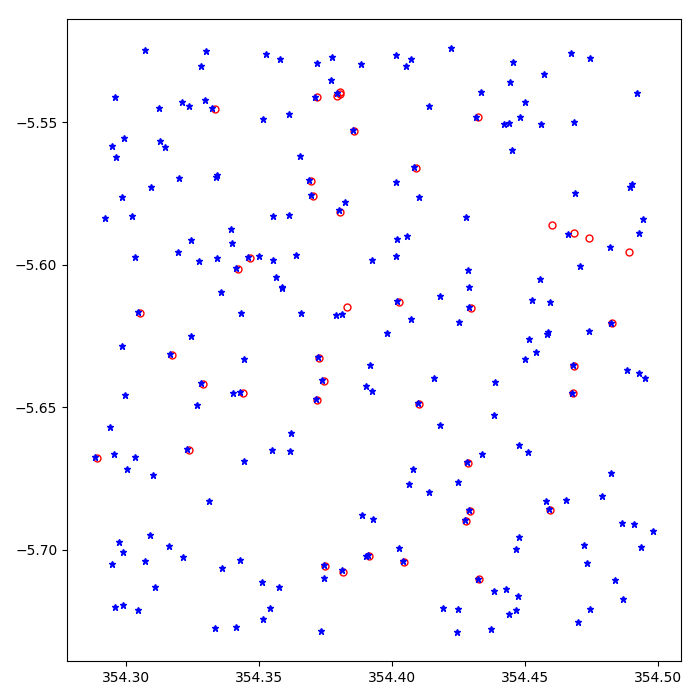

In [13]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#SHOW THE STARS IN THE FIELD
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
iimg=0
imgsources=allsources[allsources.IMG==iimg][allsources.MAG_BEST<-12]
fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
ax=axs

#Show the sources
ax.plot(imgsources["ALPHA_J2000"],imgsources["DELTA_J2000"],'ro',ms=5,mfc='None')
ax.plot(stars["ALPHA_J2000"],stars["DELTA_J2000"],'b*',ms=5)

fig.tight_layout()
fig.savefig(OUT_DIR+"stars.png")

In [14]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#MATCH IMAGE AND STAR DATABASE
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
print("Matching stars...")
a="ALPHA_J2000"
d="DELTA_J2000"

for i,image in enumerate(images):
    file=image["file"]
    imgsources=allsources[allsources.IMG==i]
    bright=imgsources[imgsources.MAG_BEST<-14]
    nbright=len(bright)

    #Comparing set of sources
    print("\tMatching for image %s"%file)    
    print("\t\tNumber of selected bright stars:",len(bright))
    print("\t\tPresent average distance to stars:",distanceSets([0,0],bright,stars,a,d)/nbright/ARCSEC)
        
    #Find optimal translation
    solution=minimize(distanceSets,[0,0],method='Nelder-Mead',tol=1e-6,args=(bright,stars,a,d))
    image["translation"]=solution.x

    print("\t\tMatching parameters:",image["translation"])
    print("\t\tImproved average distance:",distanceSets(image["translation"],bright,stars,a,d)/nbright/ARCSEC)
    
    #Translate position of stars
    bright[[a,d]]=[translation2D(image["translation"],[alpha,delta])\
                                 for alpha,delta in zip(bright[a],bright[d])]

    #Match bright sources and stars
    stars_ind=matchSets(bright,stars,a,d)
    zeros=stars.loc[stars_ind,"Rmag"].values-bright["MAG_BEST"].values
    image["zeropoint"]=zeros.mean()
    image["zerostd"]=zeros.std()
    
    #Aligning positions
    print("\t\tAligning")    
    tr=SimilarityTransform()
    status=tr.estimate(bright[[a,d]].values,stars.loc[stars_ind,[a,d]].values)
    print("\t\t\tSuccess:",status)
    image["astrometry"]=tr
    
    #Alligning all sources
    xy=imgsources[[a,d]].values
    xya=[]
    for j in range(xy.shape[0]):
        xyr=xy[j,:]
        xyr=translation2D(image["translation"],xyr)
        xyr=image["astrometry"](xyr).tolist()
        xya+=xyr
    xya=np.array(xya)
    
    imgsources[["RA","DEC"]]=pd.DataFrame(xya,columns=["RA","DEC"],index=imgsources.index)
    allsources.loc[allsources.IMG==i,["RA","DEC"]]=imgsources
    
    #Photometric properties
    allsources.loc[allsources.IMG==i,["MAG_ASTRO"]]=imgsources["MAG_BEST"]+image["zeropoint"]
    allsources.loc[allsources.IMG==i,["ERR_MAG_ASTRO"]]=(imgsources["MAGERR_BEST"]**2+image["zerostd"]**2).apply(np.sqrt)
    
    #Last verification
    imgsources=allsources[allsources.IMG==i]
    bright=imgsources[imgsources.MAG_BEST<-14]
    nstars=stars.rename(columns={"ALPHA_J2000":"RA","DELTA_J2000":"DEC"})
    print("\t\tAverage distance to stars after astrometry:",distanceSets([0,0],bright,nstars,"RA","DEC")/nbright/ARCSEC)
print("Done.")

Matching stars...
	Matching for image o8010g0343o.1300828.ch.1992524.XY63.p01
		Number of selected bright stars: 16
		Present average distance to stars: 4.56551993073
		Matching parameters: [-0.00068964 -0.4214485 ]
		Improved average distance: 2.90465035416
		Aligning
			Success: True
		Average distance to stars after astrometry: 4.03988189492
	Matching for image o8010g0361o.1300846.ch.1992542.XY63.p01
		Number of selected bright stars: 19
		Present average distance to stars: 3.27560704324
		Matching parameters: [-0.00069314 -0.38899512]
		Improved average distance: 1.71649399046
		Aligning
			Success: True
		Average distance to stars after astrometry: 1.75431821273
	Matching for image o8010g0379o.1300864.ch.1992560.XY63.p01
		Number of selected bright stars: 18
		Present average distance to stars: 3.48984950595
		Matching parameters: [-0.00064024 -0.42693734]
		Improved average distance: 2.01990020875
		Aligning
			Success: True
		Average distance to stars after astrometry: 2.5923605

<IPython.core.display.Javascript object>


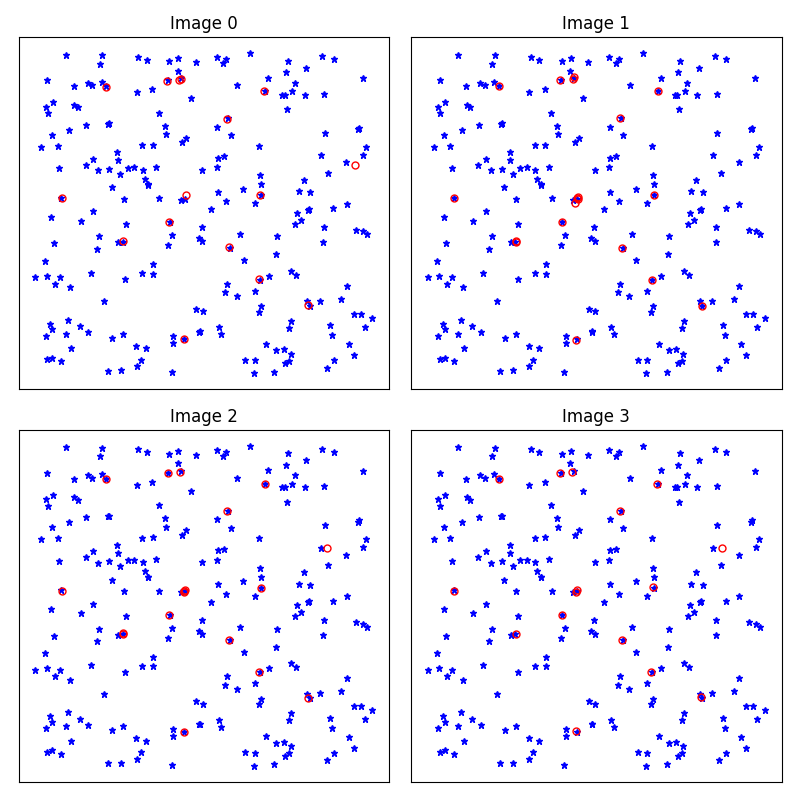

In [15]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#PLOT IMAGE MATCH
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
npx=int(len(images)/2)

fig,axs=plt.subplots(npx,2,sharex=True,sharey=True,figsize=(2*4,4*npx))
axl=mat2lst(axs)

for i,image in enumerate(images):

    imgsources=allsources[allsources.IMG==i]
    bright=imgsources[imgsources.MAG_BEST<-14]
    
    #Show the sources
    axl[i].plot(stars.loc[stars.index[:]]["ALPHA_J2000"],stars.loc[stars.index[:]]["DELTA_J2000"],'b*',ms=5)
    axl[i].plot(bright.loc[bright.index[:]]["RA"],bright.loc[bright.index[:]]["DEC"],'ro',ms=5,mfc='None')
    
    axl[i].set_title("Image %d"%i)
    axl[i].set_xticks([])
    axl[i].set_yticks([]) 
    #break
    
fig.tight_layout()
fig.savefig(OUT_DIR+"stars-%d.png"%i)

---

## Step 6: Detect potential moving objects

At this step we will check which of the sources appear on just one image.  They are the potential moving objects.

In [16]:
#############################################################
#1-FIND POTENTIAL MOVING OBJECTS
#############################################################
print("Find potential moving objects...")
print("\tSearching RADIUS (pixels, arcsec):",CONF.RADIUS,CONF.RADIUS*PXSIZE/ARCSEC)
RADIUS=CONF.RADIUS

iobj=1
for i,ind in enumerate(allsources.index):
    obj=allsources.loc[ind]
    x=obj.X_ALIGN;y=obj.Y_ALIGN
    if obj.NIMG>1:continue

    #COMPUTE THE EUCLIDEAN DISTANCE TO ALL OBJECTS NOT FOUND YET
    cond=allsources.NIMG==1
    searchobjs=allsources[cond]
    ds=((x-searchobjs.X_ALIGN)**2+(y-searchobjs.Y_ALIGN)**2).apply(np.sqrt)

    #IN HOW MANY IMAGES THE OBJECT IS PRESENT
    cond=ds<RADIUS
    inds=searchobjs[cond].index
    nimg=len(allsources.ix[inds])
    allsources.loc[inds,"NIMG"]=nimg

    #ASSIGN OBJECT NUMBER
    if nimg==4:
        allsources.loc[inds,"OBJ"]=iobj
        iobj+=1

moving=allsources[allsources.NIMG<2]
rest=allsources[allsources.NIMG>=2]
print("\tNumber of potentially moving objects: ",len(moving))

Find potential moving objects...
	Searching RADIUS (pixels, arcsec): 3 0.766783666346
	Number of potentially moving objects:  218


<IPython.core.display.Javascript object>


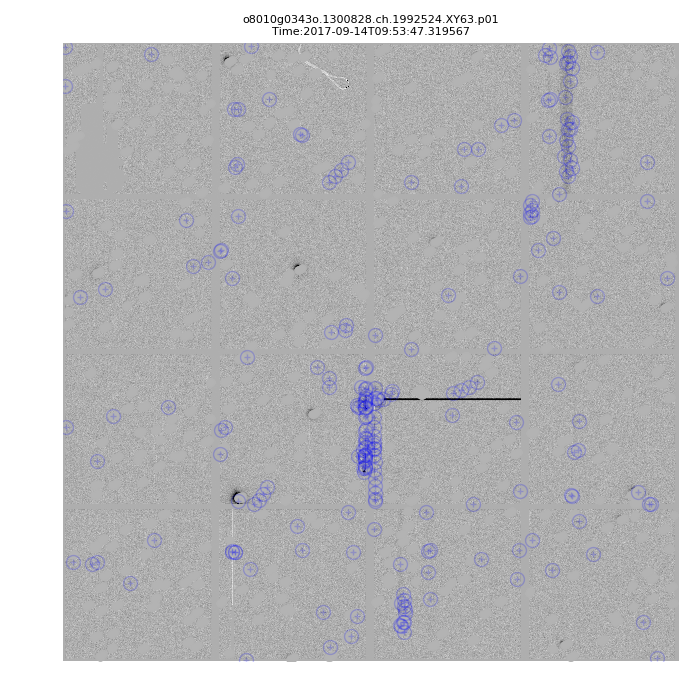

In [17]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#SHOW THE PTENTIAL MOVING OBJECTS
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#Which image do you want the sources be shown?
iimg=0
image=images[iimg]

fig,axs=plt.subplots(1,1,sharex=True,sharey=True,figsize=(7,7))
ax=axs
imgargs=dict(cmap='gray_r',vmin=0,vmax=500)
ax.imshow(image["data"],**imgargs)       
ax.axis("off")
time=image["header"]["DATE-OBS"]
ax.set_title(image["file"]+"\n"+"Time:"+time,fontsize=8,position=(0.5,1.0))

#Show the sources
gray=plt.get_cmap('gray')
ax.plot(rest["X_IMAGE"]-1,rest["Y_IMAGE"],'o',color=gray(0.7),ms=5,alpha=1)
ax.plot(rest["X_IMAGE"]-1,rest["Y_IMAGE"],'o',color=gray(0.7),ms=5,alpha=1)
ax.plot(moving["X_IMAGE"]-1,moving["Y_IMAGE"],'bo',ms=10,mfc='None',alpha=0.2)
ax.plot(moving["X_IMAGE"]-1,moving["Y_IMAGE"],'b+',ms=5,mfc='None',alpha=0.2)

fig.tight_layout()
fig.savefig(OUT_DIR+"moving.png")

**NOTES**: Objects in rest have been masked (gray circles) to highlight the moving objects which are in the center of the blue circles.

---

## Step 7: Detect the asteroids

<IPython.core.display.Javascript object>


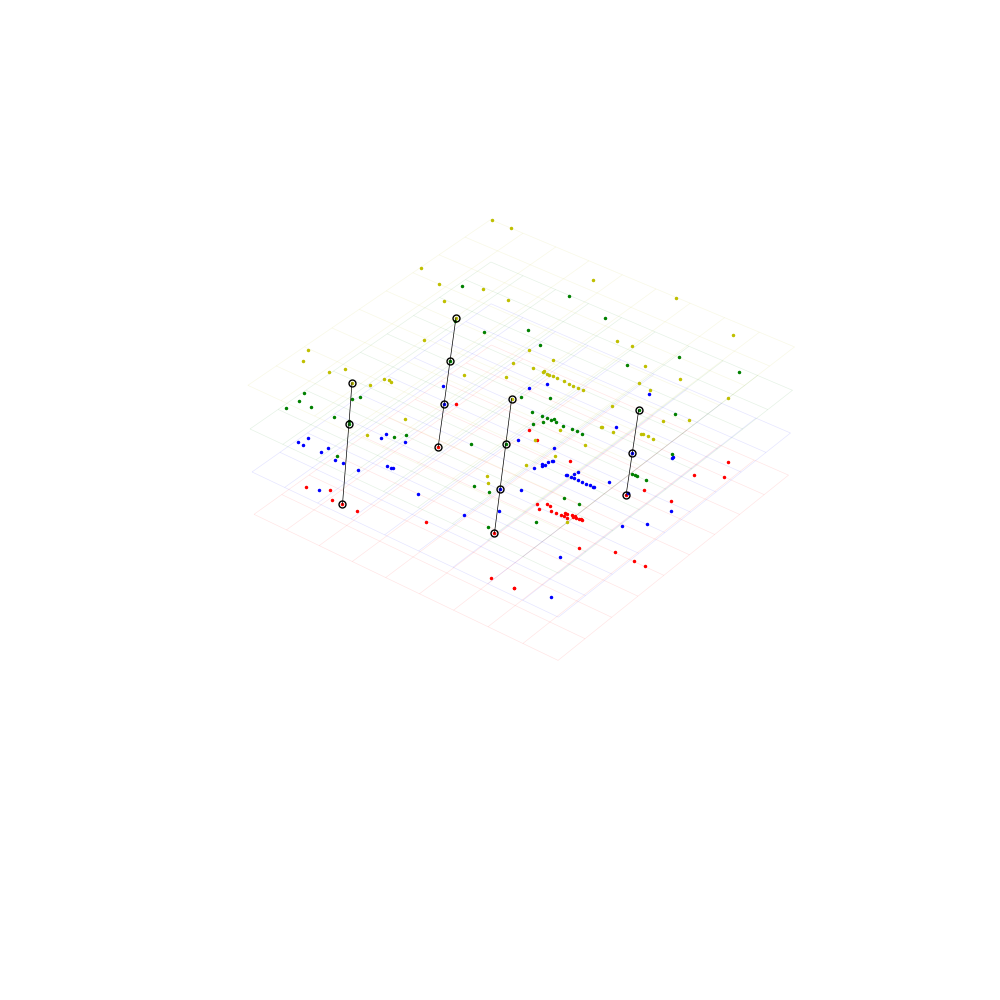

In [18]:
plt.ion()
fig3d = plt.figure(figsize=(10,10))
ax3d = fig3d.add_subplot(111, projection='3d')


xmin=allsources["X_ALIGN"].min()
xmax=allsources["X_ALIGN"].max()
ymin=allsources["Y_ALIGN"].min()
ymax=allsources["Y_ALIGN"].max()

xs=np.linspace(xmin,xmax,10)
ys=np.linspace(ymin,ymax,10)
X,Y=np.meshgrid(xs,ys)

colors=['r','b','g','y']
nimg=len(images)
for i,image in enumerate(images):
    objects=moving[moving.IMG==i][["X_ALIGN","Y_ALIGN"]].values
    Z=i*np.ones_like(X)
    ax3d.plot_wireframe(X,Y,Z,lw=0.5,color=colors[i%nimg],alpha=0.1)
    ax3d.plot(objects[:,0],objects[:,1],i,'o',color=colors[i%nimg],ms=1.5)

#ax3d.set_zticks(np.arange(len(images)))
#ax3d.set_zlabel("Image")

ax3d.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax3d.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax3d.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax3d.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax3d.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax3d.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax3d.set_xticks([])
ax3d.set_yticks([])
ax3d.set_zticks([])

ax3d.set_zlim((-4,4))
ax3d.view_init(5,30)

**NOTES**: Colors are, red for image 0, blue for image 1, green for image 2 and yellow for image 3.

In [20]:
################################################################################
#PREPARATION
################################################################################
#Numbers
nimgs=len(images)
nmax=nimgs-3
ix="X_ALIGN"
iy="Y_ALIGN"

#Layers and times
ninds=[]
layers=[]
dts=np.zeros((nimgs,nimgs))
for i in range(nimgs):
    image=images[i]
    layers+=[moving[moving.IMG==i].sort_values(by=['X_ALIGN','Y_ALIGN'])]
    ninds+=[len(layers[-1])]
    for j in range(len(images)):
        dts[i,j]=images[j]["unixtime"]-images[i]["unixtime"]

#Ranges
xmax=max(allsources.X_ALIGN);xmin=min(allsources.X_ALIGN)
ymax=max(allsources.Y_ALIGN);ymin=min(allsources.Y_ALIGN)
        
ntot=ninds[0]*(ninds[1]+ninds[2])+ninds[1]*(ninds[2]+ninds[3])+ninds[2]*ninds[3]
print("Estimate number of rulers:",ntot)
print("Times between images:")
PP(dts)

Estimate number of rulers: 14845
Times between images:
array([[    0.        ,  1035.02130914,  2067.10372806,  3096.54458094],
       [-1035.02130914,     0.        ,  1032.08241892,  2061.5232718 ],
       [-2067.10372806, -1032.08241892,     0.        ,  1029.44085288],
       [-3096.54458094, -2061.5232718 , -1029.44085288,     0.        ]])


In [33]:
################################################################################
#CREATE RULERS
################################################################################
moving["MOBJ"]=0
dobj=[]
mobj=1
for ind in moving.index:moving.loc[ind,"MOBJ"]=0
for i in range(nimgs):
    #i=1 #Starts in the second image
    print("Layer %d:"%i)
    ref=layers[i]
    print("\tNumber of sources:",len(ref))
    for j in range(i+1,nimgs):
        if i==j:continue
        print("\tKick layer %d:"%j)
        kic=layers[j]
        print("\t\tNumber of sources:",len(kic))
        dt=dts[i,j]
        print("\t\tTime between layers:",dt)
        
        #Create rulers
        for indr in ref.index[:]:
            #indr=987 #Normal
            #indr=1166 #Starts in the second image
            #indr=744 #Skips second 
            #print("Object %d (%d)"%(indr,moving.loc[indr,"MOBJ"]))
            #print("\t\tObject position:",ref.loc[indr,[ix,iy]].values)
            if moving.loc[indr,"MOBJ"]>0:continue
            rulers=[]
            for indk in kic.index:
                if moving.loc[indk,"MOBJ"]>0:continue
                #indk=1057 #Normal
                #indk=947
                #indk=822 #Skips second
                vx=(kic.loc[indk,ix]-ref.loc[indr,ix])/dt
                vy=(kic.loc[indk,iy]-ref.loc[indr,iy])/dt

                #If contiguous object is too close it may be an error
                d=np.sqrt((vx*dt)**2+(vy*dt)**2)
                if d<10*CONF.RADIUS:continue
                
                ruler=[]
                for k in range(nimgs):
                    ruler+=[[images[k]["unixtime"],
                             ref.loc[indr,ix]+vx*dts[i,k],
                             ref.loc[indr,iy]+vy*dts[i,k],
                             ref.loc[indr,"MAG_ASTRO"]]]
                ruler=np.array(ruler)
                if ((ruler[:,1]>xmax)|(ruler[:,1]<xmin)).sum()>nmax or \
                   ((ruler[:,2]>ymax)|(ruler[:,2]<ymin)).sum()>nmax:
                    continue

                rulers+=[ruler]
                #print(ruler)
                    
                #matchRuler(ruler,moving,i,j)
                hits=np.zeros(4)
                objs=-1*np.ones(4)
                for k in range(nimgs):
                    if k==i:
                        hits[k]=1
                        objs[k]=indr
                    if k==j:
                        hits[k]=1    
                        objs[k]=indk
                    else:
                        ds=((ruler[k,1]-moving.loc[(moving.IMG==k)&(moving.MOBJ==0),ix])**2+(ruler[k,2]-moving.loc[(moving.IMG==k)&(moving.MOBJ==0),iy])**2).apply(np.sqrt)
                        if ds.min()<CONF.RADIUS:
                            hits[k]=1
                            objs[k]=ds.idxmin()
                if hits.sum()>=3:
                    print("\t\t\tObject %d detected"%mobj)
                    print("\t\t\tObject indexes:",objs)
                    
                    #Plot line
                    points=[]
                    print("\t\t\tMagnitudes:")
                    mags=[]
                    xs=[]
                    ys=[]
                    impoints=[]
                    for ind in objs:
                        if ind<0:continue
                        points+=[moving.loc[ind,[ix,iy]].values]
                        impoints+=[moving.loc[ind,"IMG"]]
                        mags+=[moving.loc[ind,"MAG_BEST"]]
                        xs+=[moving.loc[ind,"X_IMAGE"]]
                        ys+=[moving.loc[ind,"Y_IMAGE"]]
                        print("\t\t\t\tMag %d = %.1f"%(ind,mags[-1]))
                    
                    points=np.array(points)
                    magvar=np.array(mags).std()
                    xvar=np.array(xs).std()
                    yvar=np.array(ys).std()
                    
                    print("\t\t\t\tCoordinate variance (%.2f) = "%CONF.RADIUS,xvar,yvar)
                    if xvar<CONF.RADIUS or yvar<CONF.RADIUS:
                        print("\t\t\t\t***Object rejected by coordinate variance***")
                        continue

                    print("\t\t\t\tMag variance = %.2f"%(magvar))
                    if magvar>0.2:
                        print("\t\t\t\t***Object rejected by magnitude variance***")
                        continue
                             
                    moving.loc[objs[objs>0].tolist(),"MOBJ"]=mobj

                    #Plot a line
                    ax3d.plot(points[:,0],points[:,1],impoints,'ko-',lw=0.5,ms=5,mfc='None')
            
                    mobj+=1

#############################################################
#SAVE IMAGE
#############################################################
fig3d.savefig(OUT_DIR+"objects3d.png",bbox_inches='tight',pad_inches = 0,transparent = True)
                
#Compile information about detected objects 
indxs=moving[moving.MOBJ>0].index
mobjs=np.unique(moving.MOBJ.values)
nobj=len(mobjs[mobjs>0])
print("Number of detected objects:",nobjs)

Layer 0:
	Number of sources: 43
	Kick layer 1:
		Number of sources: 57
		Time between layers: 1035.02130914
			Object 1 detected
			Object indexes: [ 561.  587.  521.  930.]
			Magnitudes:
				Mag 561 = -9.7
				Mag 587 = -9.6
				Mag 521 = -9.8
				Mag 930 = -8.8
				Coordinate variance (3.00) =  19.5438724846 26.0836486758
				Mag variance = 0.39
				***Object rejected by magnitude variance***
			Object 1 detected
			Object indexes: [ 445.  483.  495.  533.]
			Magnitudes:
				Mag 445 = -10.1
				Mag 483 = -9.9
				Mag 495 = -9.9
				Mag 533 = -9.8
				Coordinate variance (3.00) =  27.8747797508 29.6356627826
				Mag variance = 0.10
			Object 2 detected
			Object indexes: [  2.76000000e+02   6.40000000e+01   1.05900000e+03  -1.00000000e+00]
			Magnitudes:
				Mag 276 = -11.1
				Mag 64 = -14.1
				Mag 1059 = -8.6
				Coordinate variance (3.00) =  42.635948698 27.9785138856
				Mag variance = 2.27
				***Object rejected by magnitude variance***
			Object 2 detected
			Object indexes: 

In [38]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
#ANNOTATED
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
import time
animfile="%s/detection-%s.gif"%(OUT_DIR,CONF.SET)
print("\tAnnotated ('%s')"%animfile)

#Figure
fig=plt.figure(figsize=(8,8))

#Show first image
imgargs=dict(cmap='gray_r',vmin=0,vmax=700)
im=plt.imshow(images[0]["data"],animated=True,**imgargs)

#Title
tm=plt.title("Set %s, Image 0: "%CONF.SET+images[0]["obstime"],fontsize=10)

#Water mark
waterMark(fig.gca())

#Show detected objects
for mobj in range(1,nobj+1):
    cond=moving.loc[indxs].MOBJ==mobj
    inds=moving.loc[indxs].index[cond]
    idobj="%s%04d"%("OBJ",mobj)
    n=1
    for ind in inds:
        obj=allsources.loc[ind]
        plt.plot(obj.X_IMAGE-1,obj.Y_IMAGE-1,'ro',ms=10,mfc='None',alpha=0.2)
        if n==1:
            plt.text(obj.X_IMAGE+5,obj.Y_IMAGE+5,"%s"%idobj,color='r',fontsize=6)
        n+=1

#Basic decoration
plt.axis("off")
fig.tight_layout()

#Update figure
def updatefig(i):
    #Select image
    iimg=i%nimgs
    im.set_array(images[iimg]["data"])
    tm.set_text("Set %s, Image %d: "%(CONF.SET,iimg)+images[iimg]["obstime"])
    return im,


#Create animation
ani=animation.FuncAnimation(fig,updatefig,frames=range(nimgs),
                            interval=1000,repeat_delay=1000,
                            repeat=True,blit=True)

#Save animattion
out=System("rm -rf %s/blink*"%OUT_DIR)
ani.save(OUT_DIR+'blink.html')
time.sleep(1)
out=System("convert -delay 100 $(find %s -name 'blink*.png' -o -name 'frame*.png' |grep -v '04' |sort) %s"%(OUT_DIR,animfile))
out=System("rm -rf blink*")
print("\tDone.")

	Annotated ('scratch/ps1-20170914_11_set177//detection-ps1-20170914_11_set177.gif')
	Done.


---

## Step 8: Photometry

Now that we have the objects we proceed to perform the photometry

In [42]:
#############################################################
#PERFORM PHOTOMETRY ON DETECTED OBJECTS
#############################################################
print("PSF fitting for objects")
columns=moving.columns.tolist()+["IDOBJ","IDIMG","DATE"
                                     "SNR","FWHM",
                                     "X_PSF","Y_PSF",
                                     "MAG_MEAN","MAG_MIN","MAG_MAX","MAG_RANGE","MAG_VAR",
                                     "SNR_MEAN","SNR_MIN","SNR_MAX","SNR_RANGE","SNR_VAR"]
objects=pd.DataFrame(columns=columns)

for mobj in range(1,nobj+1):

    #Get sources corresponding to object mobj
    cond=moving.loc[indxs].MOBJ==mobj
    inds=moving.loc[indxs].index[cond]

    #Create an index for this object
    idobj="%04d"%(mobj)

    print("\tObject %s:"%idobj)
    n=1
    mags=[]
    snrs=[]
    for ind in inds:

        #Get object information
        objp=allsources.loc[ind]
        iimg=int(objp.IMG)
        image=images[iimg]
        READOUT=image["header"]["HIERARCH CELL.READNOISE"]

        idimg=idobj+"."+str(n)
        objp["IDIMG"]=idimg
        objp["IDOBJ"]=idobj

        print("\t\tPSF fitting for image of object OBJ%s"%idimg)
        n+=1

        #DATE
        obstime=images[iimg]["obstime"]
        exptime=float(images[iimg]["header"]["EXPTIME"])
        parts=obstime.split(".")
        dt=datetime.strptime(parts[0],"%Y-%m-%dT%H:%M:%S")
        fday=(dt.hour+dt.minute/60.0+(dt.second+exptime/2+int(parts[1])/1e6)/3600.0)/24.0
        fday=("%.6f"%fday).replace("0.","")
        objp["DATE"]=dt.strftime("%Y %m %d.")+fday

        #GET DATA IMAGE
        data=rec2arr(images[iimg]["data"])
        x=int(objp.X_IMAGE)
        y=int(objp.Y_IMAGE)
        print("\t\t\tExpected position:",x,y)
        
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        #2D PSH FIT
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        dx=10 #Error in photometry
        dy=10 #Error in photometry
        ws=5  #Number of errors to select for fitting
        xs=np.arange(x-ws*dx,x+ws*dx,1)
        pxs=data[y,x-ws*dx:x+ws*dx,0]
        ys=np.arange(y-ws*dy,y+ws*dy,1)
        pys=data[y-ws*dy:y+ws*dy,x,0]

        sigmax2=10 #Estimated error in X
        sigmay2=10 #Estimated error in y
        meanx=x
        meany=y
        X,Y=np.meshgrid(xs,ys)
        P=data[y-ws*dy:y+ws*dy,x-ws*dx:x+ws*dx,0]

        def gaussianLevel2(tx,ty,level=0.0,amplitude=1.0,
                           meanx=meanx,meany=meany,
                           sigmax2=sigmax2,sigmay2=sigmay2):
            g=amplitude*np.exp(-0.5*((tx-meanx)**2/sigmax2+(ty-meany)**2/sigmay2))
            f=g+level
            return f

        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        #FIT RESULTS
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        g_init=custom_model(gaussianLevel2)()
        fit=fitting.SLSQPLSQFitter()
        g=fit(g_init,X,Y,P,verblevel=0)
        #print("\t\tResults (level,amplitude,meanx,meany,sigmax,sigmay):\n\t\t\t%s"%str(g.parameters))

        xc=g.meanx.value
        yc=g.meany.value
        sigmam=np.sqrt(g.sigmax2.value+g.sigmay2.value)
        amplitude=g.amplitude.value
        level=g.level.value
        objp["FWHM"]=2.355*sigmam
        objp["X_PSF"]=xc
        objp["Y_PSF"]=yc

        print("\t\t\tPSF position:",xc,yc)
        print("\t\t\tFWHM:",objp.FWHM)
        
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        #COMPUTE SNR
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        title="Object %d, %s, %s"%(ind,idimg,obstime)

        try:
            ws=5
            x=int(g.meanx.value)
            y=int(g.meany.value)
            dx=int(np.sqrt(g.sigmax2.value))
            dy=int(np.sqrt(g.sigmay2.value))
            xs=np.arange(x-ws*dx,x+ws*dx,1)
            ys=np.arange(y-ws*dy,y+ws*dy,1)
            X,Y=np.meshgrid(xs,ys)
            P=data[y-ws*dy:y+ws*dy,x-ws*dx:x+ws*dx,0]
            Pth=gaussianLevel2(X,Y,
                               level=g.level.value,amplitude=g.amplitude.value,
                               meanx=g.meanx.value,meany=g.meany.value,
                               sigmax2=g.sigmax2.value,sigmay2=g.sigmay2.value)
            D=P-Pth
            noise=D.std()
            objp["SNR"]=g.amplitude.value/noise
            print("\t\t\tSNR = ",objp.SNR)
            print("\t\t\tMAG = %.1f +/- %.2f"%(objp.MAG_ASTRO,objp.ERR_MAG_ASTRO))
        except:
            objp.SNR=-1.0
        mags+=[objp.MAG_ASTRO]
        snrs+=[objp.SNR]
        
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        #PLOT 2D FIT
        #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
        if CONF.PHOTOPLOT and objp.SNR>0:
            plt.ioff()
            fig = plt.figure()
            ax3d = fig.add_subplot(111, projection='3d')
            ax3d.plot_wireframe(X,Y,P,lw=0.5)
            ngrid=50
            Xs,Ys=np.meshgrid(np.linspace(xs[0],xs[-1],ngrid),
                              np.linspace(ys[0],ys[-1],ngrid))
            Zs=gaussianLevel2(Xs,Ys,
                              level=g.level.value,amplitude=g.amplitude.value,
                              meanx=g.meanx.value,meany=g.meany.value,
                              sigmax2=g.sigmax2.value,sigmay2=g.sigmay2.value)
            ax3d.plot_surface(Xs,Ys,Zs,cmap='hsv',alpha=0.2)
            ax3d.set_title(title,position=(0.5,1.05),fontsize=10)
            fig.savefig(OUT_DIR+"psf2d-%s.png"%idimg)

            #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
            #1D PLOT OF PSF FITTING
            #&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
            xs=np.arange(x-ws*dx,x+ws*dx,1)
            pxs=data[y,x-ws*dx:x+ws*dx,0]
            pxts=level+amplitude*np.exp(-0.5*((xs-x)**2/g.sigmax2.value))
            rxs=pxs-pxts

            ys=np.arange(y-ws*dy,y+ws*dy,1)
            pys=data[y-ws*dy:y+ws*dy,x,0]
            pyts=level+amplitude*np.exp(-0.5*((ys-y)**2/g.sigmay2.value))
            rys=pys-pyts

            xt=np.linspace(xs[0],xs[-1],100)
            pt=level+amplitude*np.exp(-0.5*((xt-x)**2/g.sigmax2.value))

            fig,axs=plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[2,1]})
            ax=axs[0]
            ax.plot((xs-x)/np.sqrt(g.sigmax2.value),pxs,'ko')
            ax.plot((ys-y)/np.sqrt(g.sigmay2.value),pys,'ko')
            ax.plot((xt-x)/np.sqrt(g.sigmax2.value),pt,'r-')
            ax.set_xlim((-ws,+ws))
            ax.set_ylim((min(pxs.min(),pys.min()),max(pxs.max(),pys.max())))
            ax.axvspan(-objp.FWHM/2/sigmam,+objp.FWHM/2/sigmam,color='b',alpha=0.2)
            ax.axhspan(0,level,color='k',alpha=0.2)
            ax.set_xticks([])
            legend=""
            legend+="SNR = %.2f\n"%objp.SNR
            legend+="FWHM (arcsec) = %.2f\n"%(objp.FWHM*PXSIZE/ARCSEC)
            legend+="MAG = %+.1f\n"%(objp.MAG_ASTRO)
            ax.text(0.95,0.95,legend,
                    ha='right',va='top',transform=ax.transAxes,color='k',fontsize=12)
            ax.set_ylabel("Counts")
            ax.set_title("Object %s"%idimg)
            waterMark(ax)

            ax=axs[1]
            ax.plot((xs-x)/np.sqrt(g.sigmax2.value),rxs,'ko')
            ax.plot((ys-y)/np.sqrt(g.sigmay2.value),rys,'ko')
            ax.set_ylim((-level,level))
            ax.axhspan(-noise,noise,color='k',alpha=0.2)
            ax.set_ylabel("Residual (count)")

            fig.tight_layout()
            fig.subplots_adjust(hspace=0)
            fig.savefig(OUT_DIR+"psf1d-%s.png"%idimg)

        #ADD OBJECT
        objects=objects.append(objp,ignore_index=True)

        #break
    mags=np.array(mags)
    snrs=np.array(snrs)
    
    #Storing object properties
    objects.loc[objects.IDOBJ==idobj,"MAG_MIN"]=mags.min()
    objects.loc[objects.IDOBJ==idobj,"MAG_MAX"]=mags.max()
    objects.loc[objects.IDOBJ==idobj,"MAG_RANGE"]=mags.max()-mags.min()
    objects.loc[objects.IDOBJ==idobj,"MAG_MEAN"]=mags.mean()
    objects.loc[objects.IDOBJ==idobj,"MAG_VAR"]=mags.std()

    objects.loc[objects.IDOBJ==idobj,"SNR_MIN"]=snrs.min()
    objects.loc[objects.IDOBJ==idobj,"SNR_MAX"]=snrs.max()
    objects.loc[objects.IDOBJ==idobj,"SNR_RANGE"]=snrs.max()-snrs.min()
    objects.loc[objects.IDOBJ==idobj,"SNR_MEAN"]=snrs.mean()
    objects.loc[objects.IDOBJ==idobj,"SNR_VAR"]=snrs.std()

    print("\t\tMag: [%.1f,%.1f:%.1f] %.1f +/- %.2f"%(mags.min(),mags.max(),
                                                     mags.max()-mags.min(),
                                                     mags.mean(),mags.std()))
    print("\t\tSNR: [%.1f,%.1f:%.1f] %.1f +/- %.2f"%(snrs.min(),snrs.max(),
                                                     snrs.max()-snrs.min(),
                                                     snrs.mean(),snrs.std()))

objects.to_csv(OUT_DIR+"objects-%s.csv"%CONF.SET,index=False)

PSF fitting for objects
	Object 0001:
		PSF fitting for image of object OBJ0001.1
			Expected position: 1123 468
			PSF position: 1122.17578189 467.78269373
			FWHM: 8.00019998299669
			SNR =  11.743609602106236
			MAG = 19.7 +/- 1.27
		PSF fitting for image of object OBJ0001.2
			Expected position: 1097 498
			PSF position: 1096.14181759 497.152327802
			FWHM: 6.0572945048769045
			SNR =  15.332907728201397
			MAG = 19.0 +/- 1.66
		PSF fitting for image of object OBJ0001.3
			Expected position: 1072 524
			PSF position: 1071.47647225 523.412991694
			FWHM: 5.867620958277204
			SNR =  19.15076575416668
			MAG = 19.4 +/- 1.91
		PSF fitting for image of object OBJ0001.4
			Expected position: 1048 548
			PSF position: 1047.42520083 547.257217005
			FWHM: 5.631958049213713
			SNR =  17.551387301607814
			MAG = 19.9 +/- 1.61
		Mag: [19.0,19.9:0.9] 19.5 +/- 0.35
		SNR: [11.7,19.2:7.4] 15.9 +/- 2.78
	Object 0002:
		PSF fitting for image of object OBJ0002.1
			Expected position: 1631 1334
			P

---

## Step 8: Select objects

Here we present the information about the found moving objects.

In [43]:
selfile=OUT_DIR+"select-%s.txt"%CONF.SET
f=open(selfile,"w")
print("Generating selection report...")

typo="C"
mago="R"
lines=""
header="%-5s|%-68s|%-10s|%-10s|%-10s|\n"%("ID","REPORT","SNR_MIN","SNR_MAX","MAG_RANGE")
f.write(header)
f.write("-"*len(header)+"\n")
for ind in objects.index:
    objp=objects.loc[ind]
    parts=str(objp.IDIMG).split(".")
    idimg="%04d.%1d"%(int(parts[0]),int(parts[1]))
    idobj="%s%s"%(CONF.TEAM,objp.IDOBJ)
    print("\tReport for image %s"%idimg)
    
    mag=objp.MAG_ASTRO
    ras=dec2sex(objp.RA/15)
    decs=dec2sex(objp.DEC)
    
    entry="%3s%1s%02d %02d %6.3f%02d %02d %5.2f%13.1f%2s%9s"%\
        (typo,
         objp.DATE,
         int(ras[0]),int(ras[1]),ras[2],
         int(decs[0]),int(decs[1]),decs[2],
         mag,
         mago,
         MPCCODE
        )

    line="%-5s|%-68s|%-10.2f|%-10.2f|%-10.2f|\n"%\
        (objp.IDOBJ,
         entry,
         objp.SNR_MIN,
         objp.SNR_MAX,
         objp.MAG_RANGE
        )
    lines+=line

if len(objects.index)==0:
    f.write("NO MOVING OBJECTS DETECTED\n\n")
else:
    f.write(lines)
f.close()

Generating selection report...
	Report for image 0001.1
	Report for image 0001.2
	Report for image 0001.3
	Report for image 0001.4
	Report for image 0002.1
	Report for image 0002.2
	Report for image 0002.3
	Report for image 0002.4
	Report for image 0003.1
	Report for image 0003.2
	Report for image 0003.3
	Report for image 0004.1
	Report for image 0004.2
	Report for image 0004.3


In [44]:
out=System("cat "+selfile)
Image(url=OUT_DIR+"detection-%s.gif"%CONF.SET)

ID   |REPORT                                                              |SNR_MIN   |SNR_MAX   |MAG_RANGE |
-------------------------------------------------------------------------------------------------------------
0001 |  C2017 09 14.41261423 37 46.073-5 38 39.72         19.7 R      F51 |11.74     |19.15     |0.90      |
0001 |  C2017 09 14.42459323 37 45.569-5 38 46.25         19.0 R      F51 |11.74     |19.15     |0.90      |
0001 |  C2017 09 14.43653823 37 44.862-5 38 50.48         19.4 R      F51 |11.74     |19.15     |0.90      |
0001 |  C2017 09 14.44845323 37 44.191-5 38 54.78         19.9 R      F51 |11.74     |19.15     |0.90      |
0002 |  C2017 09 14.41261423 37 34.732-5 35 27.92         20.7 R      F51 |5.47      |8.12      |0.70      |
0002 |  C2017 09 14.44845323 37 33.314-5 35 50.82         20.6 R      F51 |5.47      |8.12      |0.70      |
0002 |  C2017 09 14.43653823 37 33.823-5 35 43.27         20.3 R      F51 |5.47      |8.12      |0.70      |
0002 |  C2017 09 1

In [45]:
#Now select which objects you want to remove from report
remove=["0004"]

---

## Step 9: Finally the report!

In [46]:
fs=open(selfile,"r")

repfile=OUT_DIR+"report-%s.txt"%CONF.SET
fr=open(repfile,"w")

#Time of report                                                                                                                                                                      
NOW=datetime.now()
NOW=NOW.strftime("%Y.%m.%d %H:%M:%S")

fr.write("""COD %s
OBS %s
MEA %s (%s, %s)
TEL %s
ACK MPCReport file updated %s
NET PPMXL

Image set: %s

"""%(MPCCODE,OBSERVER,
     CONF.TEAM_MEMBERS,CONF.TEAM,CONF.TEAM_COUNTRY,
     TELESCOPE,NOW,CONF.SET))

print("Generating report %s..."%repfile)

i=0
n=1
iold=0
for line in fs.readlines():
    i+=1
    if i<=2:continue
    parts=line.strip().split("|")
    idobj=parts[0].strip()
    if idobj in remove:continue
    if iold>0 and int(idobj)!=iold:
        n+=1
    nobj="%s%04d"%(CONF.TEAM,n)
    print("\tSaving object %s (old %s)..."%(nobj,idobj))
    line="%12s%s"%(nobj,parts[1])
    fr.write("%s\n"%line)
    iold=int(idobj)
    
if len(objects.index)==0:
    fr.write("NO MOVING OBJECTS DETECTED\n\n")

fr.write("----- end -----\n")
fr.close()

Generating report scratch/ps1-20170914_11_set177/report-ps1-20170914_11_set177.txt...
	Saving object NEA0001 (old 0001)...
	Saving object NEA0001 (old 0001)...
	Saving object NEA0001 (old 0001)...
	Saving object NEA0001 (old 0001)...
	Saving object NEA0002 (old 0002)...
	Saving object NEA0002 (old 0002)...
	Saving object NEA0002 (old 0002)...
	Saving object NEA0002 (old 0002)...
	Saving object NEA0003 (old 0003)...
	Saving object NEA0003 (old 0003)...
	Saving object NEA0003 (old 0003)...


In [47]:
out=System("cat -n "+repfile)

     1	COD F51
     2	OBS N. Primak, A. Schultz, S. Watters, J. Thiel, T. Goggia
     3	MEA J.Ospina, L. Piedraita, I.Moreno, S.Lopez, J. Zuluaga (NEA, Colombia)
     4	TEL 1.8-m f/4.4 Ritchey-Chretien + CCD
     5	ACK MPCReport file updated 2018.01.08 10:58:43
     6	NET PPMXL
     7
     8	Image set: ps1-20170914_11_set177
     9
    10	     NEA0001  C2017 09 14.41261423 37 46.073-5 38 39.72         19.7 R      F51
    11	     NEA0001  C2017 09 14.42459323 37 45.569-5 38 46.25         19.0 R      F51
    12	     NEA0001  C2017 09 14.43653823 37 44.862-5 38 50.48         19.4 R      F51
    13	     NEA0001  C2017 09 14.44845323 37 44.191-5 38 54.78         19.9 R      F51
    14	     NEA0002  C2017 09 14.41261423 37 34.732-5 35 27.92         20.7 R      F51
    15	     NEA0002  C2017 09 14.44845323 37 33.314-5 35 50.82         20.6 R      F51
    16	     NEA0002  C2017 09 14.43653823 37 33.823-5 35 43.27         20.3 R      F51
    17	     NEA0002  C2017 09 14.42459323 37 34.346-5 35 

## Epilogue

There are several things that you should also do:
- Find objects that do not appear in the 4 frames.
- Perform a proper astrometry able to provide position with a precision below 1 arcsec

## Addition: Find objects in less than 4 frames

In [ ]:
#for ind in allsources.index:
#    allsources.loc[ind,"T"]=images[allsources.loc[ind,"IMG"]]["unixtime"]
#    allsources.loc[ind,"MOBJ"]=0   
for ind in moving.index:
    moving.loc[ind,"MOBJ"]=0

In [ ]:
################################################################################
#PREPARATION
################################################################################
#Numbers
nimgs=len(images)
nmax=nimgs-3
ix="X_ALIGN"
iy="Y_ALIGN"

#Layers and times
ninds=[]
layers=[]
dts=np.zeros((nimgs,nimgs))
for i in range(nimgs):
    image=images[i]
    layers+=[moving[moving.IMG==i].sort_values(by=['X_ALIGN','Y_ALIGN'])]
    ninds+=[len(layers[-1])]
    for j in range(len(images)):
        dts[i,j]=images[j]["unixtime"]-images[i]["unixtime"]

#Ranges
xmax=max(allsources.X_ALIGN);xmin=min(allsources.X_ALIGN)
ymax=max(allsources.Y_ALIGN);ymin=min(allsources.Y_ALIGN)
        
ntot=ninds[0]*(ninds[1]+ninds[2])+ninds[1]*(ninds[2]+ninds[3])+ninds[2]*ninds[3]
print("Estimate number of rulers:",ntot)
print("Times between images:")
PP(dts)

In [ ]:
# SHOW ALL OBJECTS
plt.ion()
fig,axs=plt.subplots(1,1,figsize=(8,8))

ix="X_IMAGE"
iy="Y_IMAGE"

image=images[2]
imgargs=dict(cmap='gray_r',vmin=0,vmax=500)
axs.imshow(image["data"],**imgargs)       
axs.axis("off")

colors=['r','b','g','y']
for i in range(nimgs):
    axs.plot(layers[i][ix],layers[i][iy],'o',ms=10,mfc='None',color=colors[i%nimgs])
    for ind in layers[i].index:
        obj=layers[i].loc[ind]
        #axs.text(obj[ix],obj[iy],"%d"%ind,fontsize=0)

fig.tight_layout()
#axs.invert_xaxis()
#axs.invert_yaxis()

Indexes moving object: 987,1057,1109,1077

In [ ]:
################################################################################
#CREATE RULERS
################################################################################
dobj=[]
mobj=1
for ind in moving.index:moving.loc[ind,"MOBJ"]=0
for i in range(nimgs):
    #i=1 #Starts in the second image
    print("Layer %d:"%i)
    ref=layers[i]
    print("\tNumber of sources:",len(refsources))
    for j in range(i+1,nimgs):
        if i==j:continue
        print("\tKick layer %d:"%j)
        kic=layers[j]
        print("\t\tNumber of sources:",len(kic))
        dt=dts[i,j]
        print("\t\tTime between layers:",dt)
        
        #Create rulers
        for indr in ref.index[:]:
            #indr=987 #Normal
            #indr=1166 #Starts in the second image
            #indr=744 #Skips second 
            #print("Object %d (%d)"%(indr,moving.loc[indr,"MOBJ"]))
            #print("\t\tObject position:",ref.loc[indr,[ix,iy]].values)
            if moving.loc[indr,"MOBJ"]>0:continue
            rulers=[]
            for indk in kic.index:
                if moving.loc[indk,"MOBJ"]>0:continue
                #indk=1057 #Normal
                #indk=947
                #indk=822 #Skips second
                vx=(kic.loc[indk,ix]-ref.loc[indr,ix])/dt
                vy=(kic.loc[indk,iy]-ref.loc[indr,iy])/dt

                #If contiguous object is too close it may be an error
                d=np.sqrt((vx*dt)**2+(vy*dt)**2)
                if d<10*CONF.RADIUS:continue
                
                ruler=[]
                for k in range(nimgs):
                    ruler+=[[images[k]["unixtime"],
                             ref.loc[indr,ix]+vx*dts[i,k],
                             ref.loc[indr,iy]+vy*dts[i,k],
                             ref.loc[indr,"MAG_ASTRO"]]]
                ruler=np.array(ruler)
                if ((ruler[:,1]>xmax)|(ruler[:,1]<xmin)).sum()>nmax or \
                   ((ruler[:,2]>ymax)|(ruler[:,2]<ymin)).sum()>nmax:
                    continue

                rulers+=[ruler]
                #print(ruler)
                    
                #matchRuler(ruler,moving,i,j)
                hits=np.zeros(4)
                objs=-1*np.ones(4)
                for k in range(nimgs):
                    if k==i:
                        hits[k]=1
                        objs[k]=indr
                    if k==j:
                        hits[k]=1    
                        objs[k]=indk
                    else:
                        ds=((ruler[k,1]-moving.loc[(moving.IMG==k)&(moving.MOBJ==0),ix])**2+(ruler[k,2]-moving.loc[(moving.IMG==k)&(moving.MOBJ==0),iy])**2).apply(np.sqrt)
                        if ds.min()<CONF.RADIUS:
                            hits[k]=1
                            objs[k]=ds.idxmin()
                if hits.sum()>=3:
                    print("\t\t\tObject %d detected"%mobj)
                    print("\t\t\tObject indexes:",objs)
                    
                    #Plot line
                    points=[]
                    print("\t\t\tMagnitudes:")
                    mags=[]
                    xs=[]
                    ys=[]
                    for ind in objs:
                        if ind<0:continue
                        points+=[moving.loc[ind,[ix,iy]].values]
                        mags+=[moving.loc[ind,"MAG_BEST"]]
                        xs+=[moving.loc[ind,"X_IMAGE"]]
                        ys+=[moving.loc[ind,"Y_IMAGE"]]
                        print("\t\t\t\tMag %d = %.1f"%(ind,mags[-1]))
                        
                    magvar=np.array(mags).std()
                    xvar=np.array(xs).std()
                    yvar=np.array(ys).std()
                    
                    print("\t\t\t\tCoordinate variance (%.2f) = "%CONF.RADIUS,xvar,yvar)
                    if xvar<CONF.RADIUS or yvar<CONF.RADIUS:
                        print("\t\t\t\t***Object rejected by coordinate variance***")
                        continue

                    print("\t\t\t\tMag variance = %.2f"%(magvar))
                    if magvar>0.2:
                        print("\t\t\t\t***Object rejected by magnitude variance***")
                        continue
                             
                    moving.loc[objs[objs>0].tolist(),"MOBJ"]=mobj
                    points=np.array(points)
                    axs.plot(points[:,0],points[:,1],'ko-',ms=5,mfc='None',lw=0.5)
                    axs.text(points[0,0],points[0,1],"OBJ%04d"%mobj)
                    mobj+=1
                    #break
                #break
            #print("\t\tTotal rulers for source %d:"%indr,len(rulers))
            #print("\t\tExample of ruler:\n",rulers[0])
            #break
        #break
    #break
#inds=[987,1057,1109,1077] #ALL
#inds=[0,1166,947,1047] #STARTS IN THE SECOND IMAGE
#inds=[744,822,956,779] #SKIP THE SECOND IMAGE
#for i in range(nimgs):
#    if inds[i]==0:continue
#    print("Position in layer %d:"%i,layers[i].loc[inds[i],[ix,iy]].values)

In [ ]:
moving[moving.MOBJ>0]

In [ ]:
print("Find moving objects...")
layers=[]
for i in range(len(images)):
    layers+=[moving[moving.IMG==i].sort_values(by=['X_ALIGN','Y_ALIGN'])]

#Ranges
xmax=max(allsources.X_ALIGN);xmin=min(allsources.X_ALIGN)
ymax=max(allsources.Y_ALIGN);ymin=min(allsources.Y_ALIGN)

#First level of crossing
dt1=(images[1]["unixtime"]-images[0]["unixtime"])
dt2=(images[2]["unixtime"]-images[1]["unixtime"])
dt3=(images[3]["unixtime"]-images[1]["unixtime"])

nobj=0
indxs=[]
mobj=1
for indl in layers[0].index:
    objl=layers[0].loc[indl]
    x0=objl.X_ALIGN
    y0=objl.Y_ALIGN
        
    nout=0;nfar=0;nfou=0;ntot=0
    for indu in layers[1].index:
        ntot+=1
        obju=layers[1].loc[indu]
        x1=obju.X_ALIGN
        y1=obju.Y_ALIGN
        
        #Compute speed
        vr=(obju.X_ALIGN-objl.X_ALIGN)/dt1
        vd=(obju.Y_ALIGN-objl.Y_ALIGN)/dt1

        #Check distance to close object
        d=np.sqrt((vr*dt1)**2+(vd*dt1)**2)
        if d<2*RADIUS:
            #If close object is too close continue
            continue

        #Extrapolate to next layer (Layer 2)
        xn=obju.X_ALIGN+vr*dt2
        yn=obju.Y_ALIGN+vd*dt2

        #Check if extrapolated position is beyond searching region
        if xn>xmax or xn<xmin or yn>ymax or yn<ymin:
            nout+=1
            continue

        #Search for close objects in the next layer (Layer 2)
        cond=((layers[2].Y_ALIGN-yn)**2+
              (layers[2].X_ALIGN-xn)**2).apply(np.sqrt).sort_values()<RADIUS
        exts=layers[2][cond]
        if len(exts)==0:
            #No close objects in the following layer
            nfar+=1
            continue

        dmin=((exts.Y_ALIGN-yn)**2+(exts.X_ALIGN-xn)**2).apply(np.sqrt).iat[0]
        idmin1=exts.index[0]

        #Extrapolate to next layer (Layer 3)
        xu=obju.X_ALIGN+vr*dt3
        yu=obju.Y_ALIGN+vd*dt3

        #Check if extrapolated position is beyond searching region
        if xu>xmax or xu<xmin or yu>ymax or yu<ymin:
            nout+=1
            continue

        #Search for close objects in the next layer (Layer 3)
        cond=((layers[3].Y_ALIGN-yu)**2+
              (layers[3].X_ALIGN-xu)**2).apply(np.sqrt).sort_values()<RADIUS
        exts=layers[3][cond]
        if len(exts)==0:
            nfar+=1
            continue

        dmin=((exts.Y_ALIGN-yu)**2+(exts.X_ALIGN-xu)**2).apply(np.sqrt).iat[0]
        idmin2=exts.index[0]

        if dmin<RADIUS:
            nfou+=1
            nobj+=1
            nindx=[indl,indu,idmin1,idmin2]
            
            #Plot a line
            ax3d.plot([x0,x1,xn,xu],[y0,y1,yn,yu],[0,1,2,3],'ko-',lw=0.5,ms=5,mfc='None')
            
            indxs+=nindx
            allsources.loc[nindx,"MOBJ"]=mobj
            mobj+=1

print("\t%d objects found"%nobj)
fig3d.savefig(OUT_DIR+"objects3d.png",bbox_inches='tight',pad_inches = 0,transparent = True)